In [53]:
!pip3 install pandas
!pip3 install seaborn

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Lambda, Input, Dense, SimpleRNN
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Danmini_Doorbell Data Pre-Processing

In [2]:
# Benign traffic

dd_benign = pd.read_csv('nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

# Mirai

dd_mirai_ack = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)

dd_mirai_scan = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)

dd_mirai_syn = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)

dd_mirai_udp = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)

dd_mirai_udpplain = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)

# Bashlite

dd_bashlite_combo = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)

dd_bashlite_junk = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)

dd_bashlite_scan = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)

dd_bashlite_udp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)

dd_bashlite_tcp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_udp.copy(deep=True)

In [3]:
scaler = MinMaxScaler()
df_dd_benign_norm = scaler.fit_transform(df_dd_benign)
df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)

display(pd.DataFrame(df_dd_benign_norm))
display(pd.DataFrame(df_dd_miraiack_norm))

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.142669,0.156084,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.135729,0.148615
1,0.000000,0.978503,0.000000e+00,0.000000,0.979100,0.000000e+00,0.000000e+00,0.979700,0.000000e+00,0.000000,...,3.133383e-03,0.142669,0.156084,0.420097,0.966880,7.996780e-02,0.452610,2.039017e-03,0.135729,0.148615
2,0.109455,1.000000,1.685589e-03,0.092350,1.000000,1.679639e-03,7.189790e-02,1.000000,1.767556e-03,0.052064,...,9.197633e-03,0.142669,0.156084,0.517185,0.978582,1.533787e-01,0.458088,7.501023e-03,0.135729,0.148615
3,0.000000,0.921923,0.000000e+00,0.000000,0.922485,0.000000e+00,0.000000e+00,0.923050,0.000000e+00,0.000000,...,0.000000e+00,0.142669,0.156084,0.000000,0.942177,0.000000e+00,0.441046,0.000000e+00,0.135729,0.148615
4,0.086788,0.373232,8.707131e-01,0.080347,0.408159,8.849939e-01,6.863747e-02,0.443750,9.406487e-01,0.051823,...,0.000000e+00,0.142669,0.156084,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.135729,0.148615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49543,0.000000,0.139786,0.000000e+00,0.000000,0.139871,8.509478e-17,6.572185e-07,0.139956,7.565279e-07,0.066336,...,3.345212e-16,0.142669,0.156084,0.313021,0.142857,0.000000e+00,0.134145,1.672508e-16,0.135729,0.148615
49544,0.127585,0.139786,0.000000e+00,0.101245,0.139871,8.509478e-17,7.413662e-02,0.139956,3.782664e-07,0.118560,...,3.345212e-16,0.142669,0.156084,0.313022,0.142857,0.000000e+00,0.134145,3.345016e-16,0.135729,0.148615
49545,0.255160,0.139786,1.714350e-16,0.202485,0.139871,8.509478e-17,1.482714e-01,0.139957,2.521773e-07,0.170784,...,0.000000e+00,0.142669,0.156084,0.309241,0.142857,3.242549e-08,0.134145,4.723457e-16,0.135729,0.148615
49546,0.382721,0.139786,1.714350e-16,0.303719,0.139871,0.000000e+00,2.224046e-01,0.139957,1.891322e-07,0.223008,...,3.345212e-16,0.142669,0.156084,0.313090,0.142857,2.291854e-08,0.134145,1.672508e-16,0.135729,0.148615


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
1,0.005023,1.000000,9.093668e-16,0.003467,1.000000,9.093668e-16,0.001389,1.000000,0.000000e+00,0.000155,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
2,0.009874,1.000000,0.000000e+00,0.006862,1.000000,9.093668e-16,0.002769,1.000000,9.135222e-16,0.000309,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
3,0.014914,1.000000,0.000000e+00,0.010335,1.000000,0.000000e+00,0.004159,1.000000,1.827044e-15,0.000464,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
4,0.019728,1.000000,1.818734e-15,0.013715,1.000000,9.093668e-16,0.005536,1.000000,9.135222e-16,0.000618,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102190,0.746549,0.225002,9.392910e-01,0.795662,0.221338,9.994332e-01,0.903310,0.164918,9.555176e-01,0.973470,...,0.0,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0
102191,0.751576,0.221881,9.367920e-01,0.799128,0.218124,9.992142e-01,0.904697,0.162910,9.563457e-01,0.973624,...,0.0,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0
102192,0.756613,0.218800,9.342766e-01,0.802600,0.214938,9.989618e-01,0.906086,0.160909,9.571642e-01,0.973779,...,0.0,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0
102193,0.755148,0.215735,9.317243e-01,0.801935,0.211764,9.986754e-01,0.905921,0.158910,9.579746e-01,0.973766,...,0.0,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0


# Variational Autoencoder

## Model

In [4]:
# Train set

len_benign = len(df_dd_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train = df_dd_benign_norm[:len_benign_train]

# Test set - 50% benign 50% attack

X_test_benign = df_dd_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_attack = df_dd_miraiack_norm[:len_attack_test]

X_test = np.concatenate([X_test_benign, X_test_attack])
Y_test = np.ones(len(X_test))
Y_test[:len(X_test_benign)] = 0

In [5]:
# Reparameterization trick

def sample(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    
    return z_mean + K.exp(0.5 * z_var) * epsilon

# Sample the normally distributed z - mean + sigma * epsilon. The epsilon ensures the continuity of latent space and helps
# the network to keep correcting its parameters through backpropagation

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [8]:
# Encoder Model

inputs = Input(shape = input_shape, name = 'encoder_input')
x = Dense(intermediate_dim, activation = 'relu')(inputs)

z_mean = Dense(latent_dim, name = 'z_mean')(x)
z_var = Dense(latent_dim, name = 'z_var')(x)
z = Lambda(sample, output_shape = (latent_dim,), name = 'z')([z_mean, z_var])

encoder = Model(inputs, z, name = 'encoder')
encoder.summary()

# The encoder learns a function that takes an input array of size n and can generate two vectors that represents the
# parameters (mean and variance) of a distribution from which the latent vector is sampled.

# encoder(input_vector[]) => latent_v_mu[], latent_v_lvar[]
# So that - latent_v[0] ~  N(latent_v_mu[0], latent_v_lvar[0])
# and latent_v[1] ~  N(latent_v_mu[1], latent_v_lvar[1])

W0201 21:54:55.156411 140179914532672 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 115)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 57)           6612        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 38)           2204        dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 38)           2204        dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder model

latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
outputs = Dense(original_dim, activation = 'sigmoid')(x)

# Instantiate the decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

# Transforms the latent feature space composed by distributions of mean and variance back to the original input vector

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 38)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                2223      
_________________________________________________________________
dense_2 (Dense)              (None, 115)               6670      
Total params: 8,893
Trainable params: 8,893
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name = 'vae_mlp')

In [11]:
opt = optimizers.Adam(learning_rate = 0.0001, clipvalue = 0.5)

vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 115)]             0         
_________________________________________________________________
encoder (Model)              (None, 38)                11020     
_________________________________________________________________
decoder (Model)              (None, 115)               8893      
Total params: 19,913
Trainable params: 19,913
Non-trainable params: 0
_________________________________________________________________


## Train

In [12]:
results = vae_model.fit(X_train, X_train,
                        shuffle = True,
                        epochs = 50,
                        batch_size = 50)

Epoch 1/50
34683/34683 [==============================] - 3s 82us/sample - loss: 327.0400
Epoch 2/50
34683/34683 [==============================] - 2s 65us/sample - loss: 36.1211
Epoch 3/50
34683/34683 [==============================] - 2s 67us/sample - loss: 24.5646
Epoch 4/50
34683/34683 [==============================] - 2s 64us/sample - loss: 19.9010
Epoch 5/50
34683/34683 [==============================] - 2s 64us/sample - loss: 16.7219
Epoch 6/50
34683/34683 [==============================] - 2s 65us/sample - loss: 14.1535
Epoch 7/50
34683/34683 [==============================] - 2s 66us/sample - loss: 12.3120
Epoch 8/50
34683/34683 [==============================] - 2s 64us/sample - loss: 10.9515
Epoch 9/50
34683/34683 [==============================] - 2s 66us/sample - loss: 9.9423
Epoch 10/50
34683/34683 [==============================] - 2s 63us/sample - loss: 9.1838
Epoch 11/50
34683/34683 [==============================] - 2s 65us/sample - loss: 8.5532
Epoch 12/50
34683/346

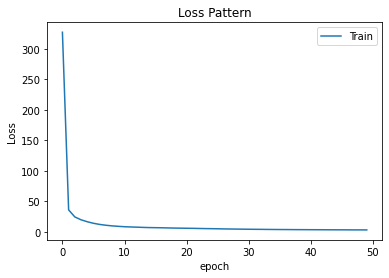

In [13]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [14]:
def get_error_term(v1, v2, _rmse = True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis = 1))
    
    return np.mean(abs(v1 - v2), axis = 1)

# Calculates the error between the original vector and the predicted one

In [15]:
X_train_pred = vae_model.predict(X_train)
error_vector = get_error_term(X_train_pred, X_train, _rmse=False)
error_thresh = np.quantile(error_vector, 0.999)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

0.11823945006829961


In [16]:
X_pred = vae_model.predict(X_test)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = get_error_term(X_pred, X_test, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

[False False False ...  True  True  True]


0.5005718129835184

## Metrics

In [17]:
print(classification_report(Y_test, attacks, digits = 6))

              precision    recall  f1-score   support

         0.0   1.000000  0.998856  0.999428     14865
         1.0   0.998858  1.000000  0.999429     14865

    accuracy                       0.999428     29730
   macro avg   0.999429  0.999428  0.999428     29730
weighted avg   0.999429  0.999428  0.999428     29730



In [18]:
# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

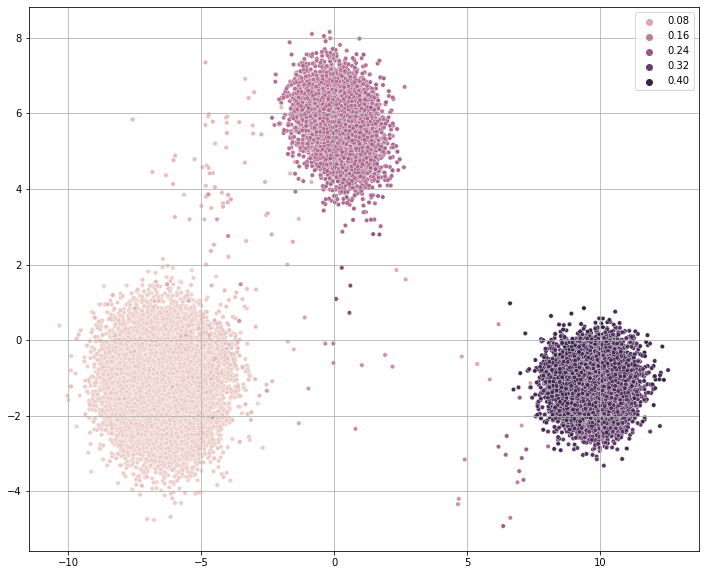

In [19]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher

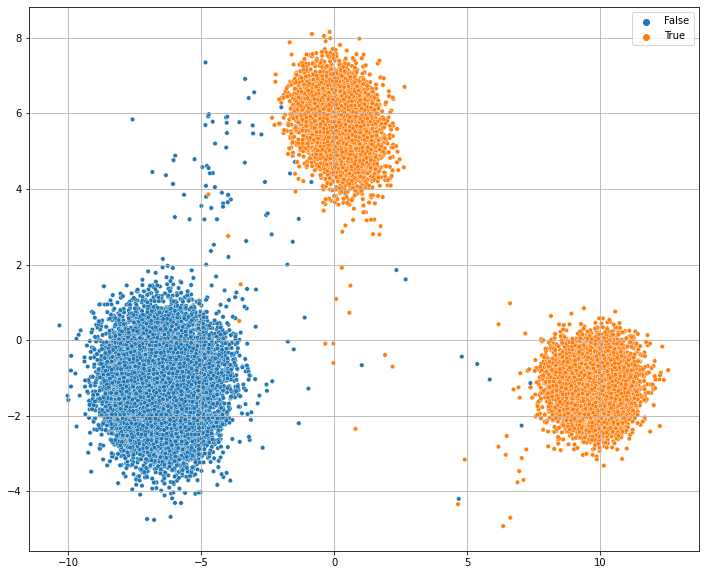

In [20]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies

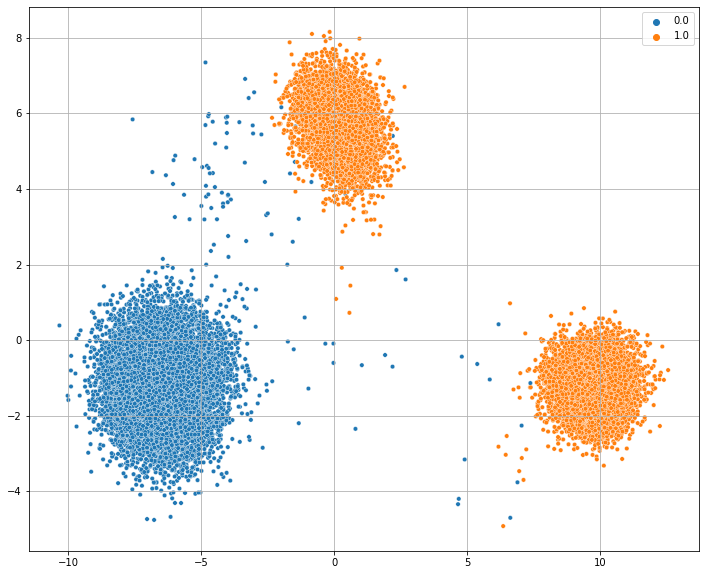

In [21]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test)
plt.grid()
plt.show()

# Ground truth

# RNN

# Data Pre-Processing

In [22]:
#scaler = MinMaxScaler()

df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

display(pd.DataFrame(df_dd_miraiudp_norm))

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.000000,1.387779e-17,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2.775558e-17,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,4.163336e-17,0.0,4.163336e-17,0.0,0.0,0.0
1,0.002929,1.387779e-17,0.000000e+00,0.002127,0.000000e+00,0.000000e+00,0.001022,0.000000e+00,7.497402e-18,0.000144,...,0.0,0.0,0.0,0.0,4.163336e-17,0.0,4.163336e-17,0.0,0.0,0.0
2,0.005864,0.000000e+00,2.236132e-17,0.004257,2.775558e-17,7.453775e-18,0.002044,2.775558e-17,0.000000e+00,0.000289,...,0.0,0.0,0.0,0.0,4.163336e-17,0.0,4.163336e-17,0.0,0.0,0.0
3,0.008799,1.387779e-17,7.453775e-18,0.006387,2.775558e-17,1.490755e-17,0.003066,2.775558e-17,0.000000e+00,0.000433,...,0.0,0.0,0.0,0.0,4.163336e-17,0.0,4.163336e-17,0.0,0.0,0.0
4,0.011735,1.387779e-17,7.453775e-18,0.008517,2.775558e-17,7.453775e-18,0.004088,5.551115e-17,7.497402e-18,0.000577,...,0.0,0.0,0.0,0.0,4.163336e-17,0.0,4.163336e-17,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237660,0.330196,8.673803e-01,4.956593e-01,0.421968,8.245635e-01,7.006565e-01,0.643010,8.400145e-01,8.634082e-01,0.924720,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
237661,0.332494,8.686666e-01,4.920505e-01,0.423610,8.257711e-01,6.981721e-01,0.643785,8.406179e-01,8.626588e-01,0.924829,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
237662,0.327315,8.699617e-01,4.884042e-01,0.419530,8.269842e-01,6.956659e-01,0.641657,8.412224e-01,8.619061e-01,0.924521,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0
237663,0.324579,8.712561e-01,4.847471e-01,0.417301,8.281977e-01,6.931487e-01,0.640456,8.418270e-01,8.611512e-01,0.924345,...,0.0,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0


In [23]:
# Mirai attack

label_mirai_ack = list(np.full(102195, 1))
miraiack_norm = pd.DataFrame(df_dd_miraiack_norm)
miraiack_norm['Label'] = label_mirai_ack

label_mirai_scan = list(np.full(107685, 2))
miraiscan_norm = pd.DataFrame(df_dd_miraiscan_norm)
miraiscan_norm['Label'] = label_mirai_scan

label_mirai_syn = list(np.full(122573, 3))
miraisyn_norm = pd.DataFrame(df_dd_miraisyn_norm)
miraisyn_norm['Label'] = label_mirai_syn

label_mirai_udp = list(np.full(237665, 4))
miraiudp_norm = pd.DataFrame(df_dd_miraiudp_norm)
miraiudp_norm['Label'] = label_mirai_udp

label_mirai_udpplain = list(np.full(81982, 5))
miraiudpplain_norm = pd.DataFrame(df_dd_miraiudpplain_norm)
miraiudpplain_norm['Label'] = label_mirai_udpplain

# Bashlite attack

label_bashlite_combo = list(np.full(59718, 6))
bashlitecombo_norm = pd.DataFrame(df_dd_bashlitecombo_norm)
bashlitecombo_norm['Label'] = label_bashlite_combo

label_bashlite_junk = list(np.full(29068, 7))
bashlitejunk_norm = pd.DataFrame(df_dd_bashlitejunk_norm)
bashlitejunk_norm['Label'] = label_bashlite_junk

label_bashlite_scan = list(np.full(29849, 8))
bashlitescan_norm = pd.DataFrame(df_dd_bashlitescan_norm)
bashlitescan_norm['Label'] = label_bashlite_scan

label_bashlite_udp = list(np.full(105874, 9))
bashliteudp_norm = pd.DataFrame(df_dd_bashliteudp_norm)
bashliteudp_norm['Label'] = label_bashlite_udp

label_bashlite_tcp = list(np.full(105874, 10))
bashlitetcp_norm = pd.DataFrame(df_dd_bashlitetcp_norm)
bashlitetcp_norm['Label'] = label_bashlite_tcp

display(pd.DataFrame(miraiack_norm))

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,Label
0,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1
1,0.005023,1.000000,9.093668e-16,0.003467,1.000000,9.093668e-16,0.001389,1.000000,0.000000e+00,0.000155,...,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1
2,0.009874,1.000000,0.000000e+00,0.006862,1.000000,9.093668e-16,0.002769,1.000000,9.135222e-16,0.000309,...,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1
3,0.014914,1.000000,0.000000e+00,0.010335,1.000000,0.000000e+00,0.004159,1.000000,1.827044e-15,0.000464,...,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1
4,0.019728,1.000000,1.818734e-15,0.013715,1.000000,9.093668e-16,0.005536,1.000000,9.135222e-16,0.000618,...,0.0,0.0,0.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102190,0.746549,0.225002,9.392910e-01,0.795662,0.221338,9.994332e-01,0.903310,0.164918,9.555176e-01,0.973470,...,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0,1
102191,0.751576,0.221881,9.367920e-01,0.799128,0.218124,9.992142e-01,0.904697,0.162910,9.563457e-01,0.973624,...,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0,1
102192,0.756613,0.218800,9.342766e-01,0.802600,0.214938,9.989618e-01,0.906086,0.160909,9.571642e-01,0.973779,...,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0,1
102193,0.755148,0.215735,9.317243e-01,0.801935,0.211764,9.986754e-01,0.905921,0.158910,9.579746e-01,0.973766,...,0.0,0.0,0.0,1.387779e-17,0.0,1.387779e-17,0.0,0.0,0.0,1


# RNN

## Model

In [47]:
# Train set

len_mirai_ack = len(miraiack_norm)
len_mirai_ack_train = int(0.7 * len_mirai_ack)
X_train_mirai_ack = miraiack_norm[:len_mirai_ack_train]

len_mirai_scan = len(miraiscan_norm)
len_mirai_scan_train = int(0.7 * len_mirai_scan)
X_train_mirai_scan = miraiscan_norm[:len_mirai_scan_train]

len_mirai_syn = len(miraisyn_norm)
len_mirai_syn_train = int(0.7 * len_mirai_syn)
X_train_mirai_syn = miraisyn_norm[:len_mirai_syn_train]

len_mirai_udp = len(miraiudp_norm)
len_mirai_udp_train = int(0.7 * len_mirai_udp)
X_train_mirai_udp = miraiudp_norm[:len_mirai_udp_train]

len_mirai_udpplain = len(miraiudpplain_norm)
len_mirai_udpplain_train = int(0.7 * len_mirai_udpplain)
X_train_mirai_udpplain = miraiudpplain_norm[:len_mirai_udpplain_train]

len_bashlite_combo = len(bashlitecombo_norm)
len_bashlite_combo_train = int(0.7 * len_bashlite_combo)
X_train_bashlite_combo = bashlitecombo_norm[:len_bashlite_combo_train]

len_bashlite_junk = len(bashlitejunk_norm)
len_bashlite_junk_train = int(0.7 * len_bashlite_junk)
X_train_bashlite_junk = bashlitejunk_norm[:len_bashlite_junk_train]

len_bashlite_scan = len(bashlitescan_norm)
len_bashlite_scan_train = int(0.7 * len_bashlite_scan)
X_train_bashlite_scan = bashlitescan_norm[:len_bashlite_scan_train]

len_bashlite_udp = len(bashliteudp_norm)
len_bashlite_udp_train = int(0.7 * len_bashlite_udp)
X_train_bashlite_udp = bashliteudp_norm[:len_bashlite_udp_train]

len_bashlite_tcp = len(bashlitetcp_norm)
len_bashlite_tcp_train = int(0.7 * len_bashlite_tcp)
X_train_bashlite_tcp = bashlitetcp_norm[:len_bashlite_tcp_train]

np_train = np.concatenate([X_train_mirai_ack, X_train_mirai_scan, X_train_mirai_syn, X_train_mirai_udp, X_train_mirai_udpplain,
                          X_train_bashlite_combo, X_train_bashlite_junk, X_train_bashlite_scan, X_train_bashlite_udp,
                          X_train_bashlite_tcp])

df_train = pd.DataFrame(np_train)
label_train = df_train.pop(115)
X_train = df_train.to_numpy()

Y_train = label_train.to_numpy()

display(pd.DataFrame(X_train))
display(pd.DataFrame(Y_train))

# Test set

X_test_mirai_ack = miraiack_norm[len_mirai_ack_train:]
len_test = len(X_test_mirai_ack)

X_test_mirai_scan = miraiscan_norm[:len_test]
X_test_mirai_syn = miraisyn_norm[:len_test]
X_test_mirai_udp = miraiudp_norm[:len_test]
X_test_mirai_udpplain = miraiudpplain_norm[:len_test]

X_test_bashlite_combo = bashlitecombo_norm[:len_test]
X_test_bashlite_junk = bashlitejunk_norm[:len_test]
X_test_bashlite_scan = bashlitescan_norm[:len_test]
X_test_bashlite_udp = bashlitetcp_norm[:len_test]
X_test_bashlite_tcp = bashlitetcp_norm[:len_test]

np_test = np.concatenate([X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp, X_test_mirai_udpplain,
                          X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan, X_test_bashlite_udp,
                          X_test_bashlite_tcp])

df_test = pd.DataFrame(np_test)
label_test = df_test.pop(115)
X_test = df_test.to_numpy()

Y_test = label_test.to_numpy()

display(pd.DataFrame(X_test))
display(pd.DataFrame(Y_test))


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.000000,1.0,0.000000e+00,0.000000,1.0,0.000000e+00,0.000000,1.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
1,0.005023,1.0,9.093668e-16,0.003467,1.0,9.093668e-16,0.001389,1.000000e+00,0.000000e+00,0.000155,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
2,0.009874,1.0,0.000000e+00,0.006862,1.0,9.093668e-16,0.002769,1.000000e+00,9.135222e-16,0.000309,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
3,0.014914,1.0,0.000000e+00,0.010335,1.0,0.000000e+00,0.004159,1.000000e+00,1.827044e-15,0.000464,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
4,0.019728,1.0,1.818734e-15,0.013715,1.0,9.093668e-16,0.005536,1.000000e+00,9.135222e-16,0.000618,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687728,0.000000,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.387779e-17,0.000000e+00,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
687729,0.000000,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.387779e-17,0.000000e+00,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
687730,0.000000,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.387779e-17,0.000000e+00,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
687731,0.000000,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.387779e-17,0.000000e+00,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
687728,10.0
687729,10.0
687730,10.0
687731,10.0


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.504494,0.784417,0.573183,0.647391,0.619958,0.749618,0.853966,3.140121e-01,0.874243,0.980106,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
1,0.472792,0.786691,0.568392,0.622283,0.622068,0.746835,0.842648,3.151418e-01,0.873480,0.978795,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
2,0.459469,0.789005,0.563488,0.611216,0.624204,0.744002,0.837449,3.162767e-01,0.872711,0.978182,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
3,0.460923,0.791287,0.558625,0.611838,0.626325,0.741172,0.837540,3.174096e-01,0.871941,0.978186,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
4,0.463435,0.793533,0.553814,0.613306,0.628430,0.738350,0.838018,3.185399e-01,0.871171,0.978234,...,0.0,0.000000,0.000000,0.0,1.000000e+00,0.0,1.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.387779e-17,0.000000,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
304185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.387779e-17,0.000000,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
304186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.387779e-17,0.000000,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265
304187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.387779e-17,0.000000,0.000000,...,0.0,0.782253,0.735523,0.0,1.387779e-17,0.0,0.0,0.0,0.782573,0.750265


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
304184,10.0
304185,10.0
304186,10.0
304187,10.0


In [54]:
def RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape = input_shape, activation = activation[0]))
    model.add(Dense(units = dense_units, activation = activation[1]))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model